İnme Yok artırılıyor...


İnme Yok İşleniyor: 100%|██████████| 2272/2272 [05:52<00:00,  6.45görüntü/s]

İnme Var artırılıyor...



İnme Var İşleniyor: 100%|██████████| 2217/2217 [12:31<00:00,  2.95görüntü/s]


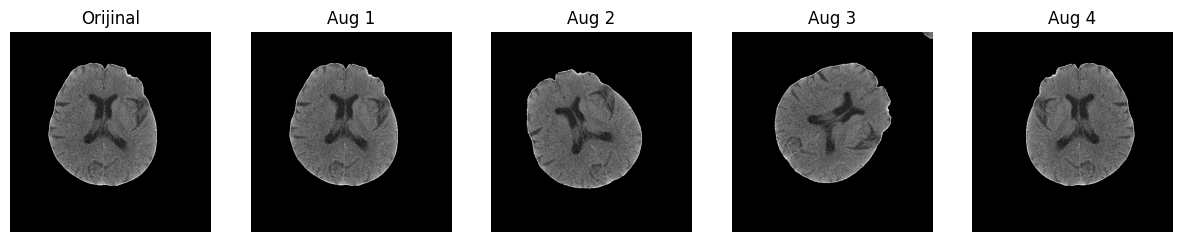

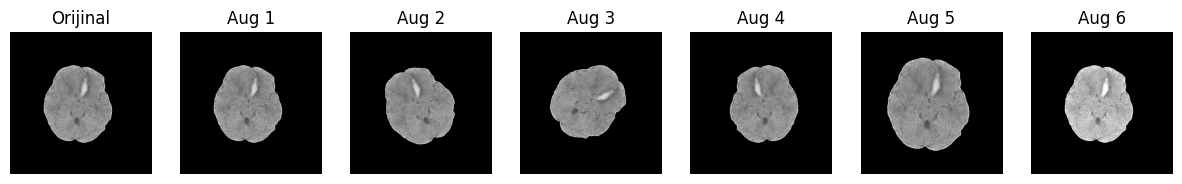

In [9]:
import cv2
import numpy as np
import os
import random
from glob import glob
from tqdm import tqdm
import multiprocessing
import matplotlib.pyplot as plt

# Klasörleri tanımla
DATASET_PATH = "/content/drive/MyDrive/dataset"
AUGMENTED_PATH = "/content/drive/MyDrive/dataset_augmented"
inme_var_path = os.path.join(DATASET_PATH, "İnmeVar")
inme_yok_path = os.path.join(DATASET_PATH, "İnmeYok")
inme_var_aug_path = os.path.join(AUGMENTED_PATH, "İnmeVar")
inme_yok_aug_path = os.path.join(AUGMENTED_PATH, "İnmeYok")

# Klasörleri oluştur
os.makedirs(inme_var_aug_path, exist_ok=True)
os.makedirs(inme_yok_aug_path, exist_ok=True)

def augment_image(img, extra=False):
    augmented_images = [img]
    h, w = img.shape[:2]

    # Döndürme (sadece 2 açı)
    angles = [30, 190]
    for angle in angles:
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
        augmented_images.append(rotated)

    # Yatay çevirme (Ayna)
    augmented_images.append(cv2.flip(img, 1))

    # Yakınlaştırma
    if extra:
        scale = 1.2
        zoomed = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        zoomed = zoomed[(zoomed.shape[0] - h)//2:(zoomed.shape[0] + h)//2, (zoomed.shape[1] - w)//2:(zoomed.shape[1] + w)//2]
        augmented_images.append(zoomed)

    # Kontrast artırma
    if extra:
        contrast = np.clip(img * 1.3, 0, 255).astype(np.uint8)
        augmented_images.append(contrast)

    return augmented_images

def process_image(args):
    file, extra, save_dir = args
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = augment_image(img, extra)
    filename, ext = os.path.splitext(os.path.basename(file))

    # Toplu kaydetme işlemi
    save_paths = [os.path.join(save_dir, f"{filename}_{i+1}{ext}") for i in range(len(augmented))]
    for aug, path in zip(augmented, save_paths):
        cv2.imwrite(path, aug)

    return file, save_paths

def process_dataset():
    inme_var_files = sorted(glob(os.path.join(inme_var_path, "*.png")))
    inme_yok_files = sorted(glob(os.path.join(inme_yok_path, "*.png")))

    # İnme Yok için rastgele seçim
    inme_yok_sample = random.sample(inme_yok_files, len(inme_yok_files) // 2)

    print("İnme Yok artırılıyor...")
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        list(tqdm(pool.imap_unordered(process_image, [(f, False, inme_yok_aug_path) for f in inme_yok_sample]),
                  total=len(inme_yok_sample), desc="İnme Yok İşleniyor", unit="görüntü"))

    print("İnme Var artırılıyor...")
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        list(tqdm(pool.imap_unordered(process_image, [(f, True, inme_var_aug_path) for f in inme_var_files]),
                  total=len(inme_var_files), desc="İnme Var İşleniyor", unit="görüntü"))

    # Görselleştirme
    visualize_augmentation(process_image((inme_yok_sample[0], False, inme_yok_aug_path)))
    visualize_augmentation(process_image((inme_var_files[0], True, inme_var_aug_path)))

def visualize_augmentation(result):
    original_file, save_paths = result
    original_img = cv2.imread(original_file)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    augmented_images = [cv2.imread(p) for p in save_paths]

    fig, axes = plt.subplots(1, len(augmented_images) + 1, figsize=(15, 5))
    axes[0].imshow(original_img)
    axes[0].set_title("Orijinal")
    axes[0].axis("off")

    for i, aug in enumerate(augmented_images):
        aug = cv2.cvtColor(aug, cv2.COLOR_BGR2RGB)
        axes[i + 1].imshow(aug)
        axes[i + 1].set_title(f"Aug {i+1}")
        axes[i + 1].axis("off")

    plt.show()

# Veri artırma işlemini başlat
process_dataset()
